# Setup

## Imports

In [17]:
import os.path
import bcolz

from tqdm import tqdm_notebook
from titlecase import titlecase
from glob import glob

vai Modules

In [18]:
import vaidata

from vaiutils import path_consts, smooth_plot, channels_last, plot_images

PyTorch Modules

In [3]:
import torch

import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable

## Define useful variables and functions

In [4]:
for k, v in path_consts('COCO'):
    exec(k + '=v')

In [5]:
def pickle_load(filename, path=DIR_CHECKPOINTS, default=None):
    return vaidata.pickle_load(os.path.join(path, filename + '.p'), default)

In [6]:
def pickle_dump(filename, obj, path=DIR_CHECKPOINTS):
    vaidata.pickle_dump(os.path.join(path, filename + '.p'), obj)

In [8]:
def load_tensor(filename):
    return bcolz.open(filename)[:]

In [9]:
def save_model():
    torch.save(model.state_dict(), os.path.join(DIR_CHECKPOINTS, 'model.dat'))
    pickle_dump('history', history)

In [10]:
def load_model():
    global history
    if not os.path.exists(os.path.join(DIR_CHECKPOINTS, 'model.dat')):
        return
    model.load_state_dict(torch.load(
        os.path.join(DIR_CHECKPOINTS, 'model.dat')))
    history = pickle_load('history')

## Load Data

In [11]:
tokenizer = pickle_load('tokenizer', path=DIR_DATA)
captions = pickle_load('captions', path=DIR_DATA)

Using TensorFlow backend.


In [12]:
word_idx = {k: v - 1 for k, v in tokenizer.word_index.items()}

In [13]:
for k in list(captions.keys()):
    for i in range(len(captions[k])):
        captions[k][i] = np.array([c - 1 for c in captions[k][i]])

In [14]:
idx_word = {v: k for k, v in word_idx.items()}

In [15]:
vocab_size = tokenizer.num_words

In [16]:
def get_captions(caption_ids):
    if type(caption_ids) is not list:
        return titlecase(' '.join(idx_word[i].title() for i in caption_ids[1:-1]))

    return [get_captions(idx) for idx in caption_ids]

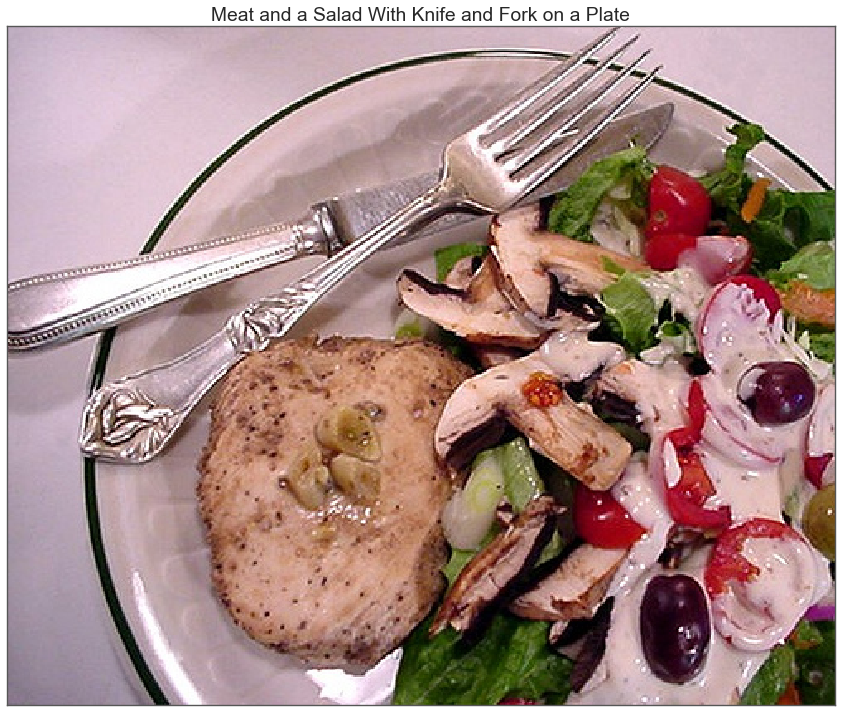

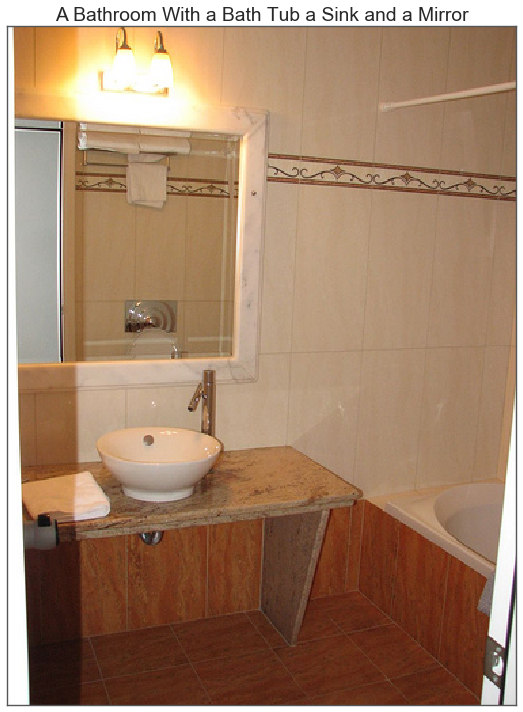

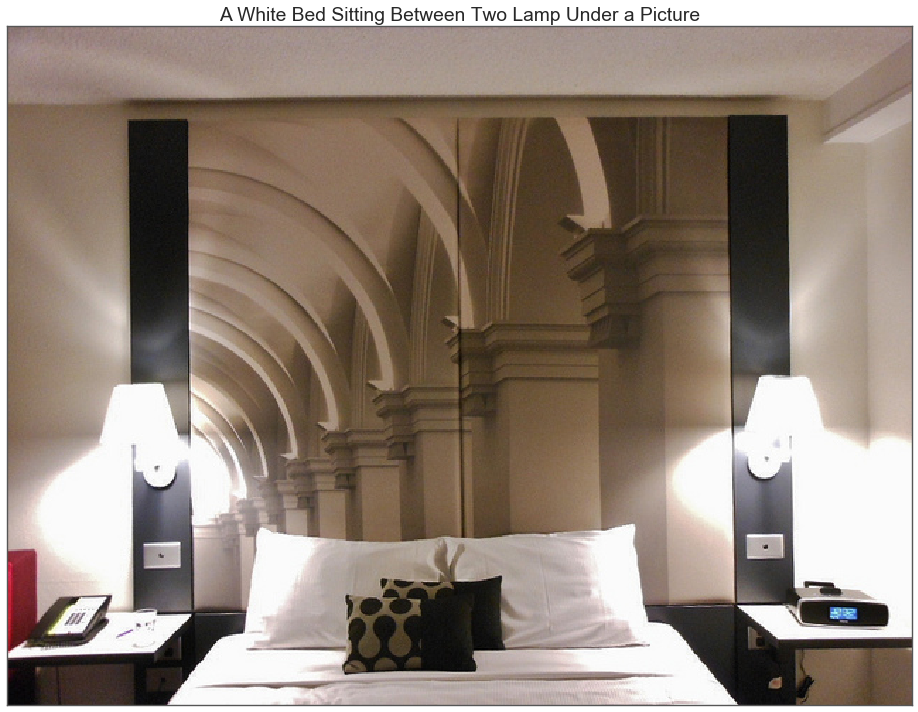

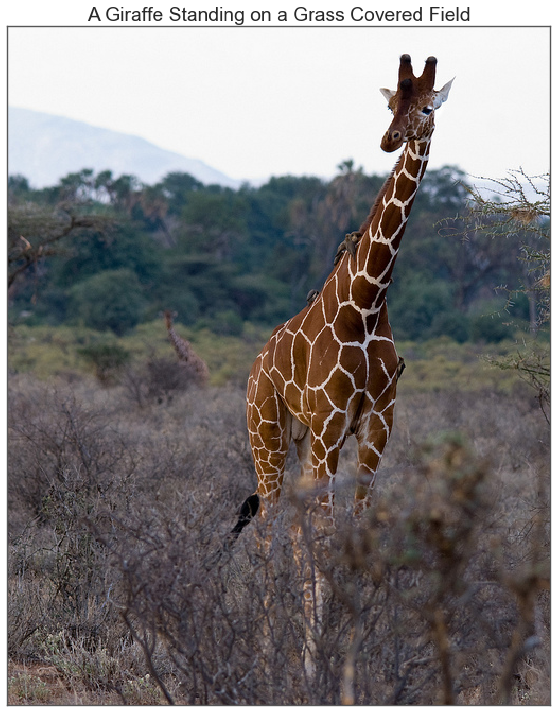

In [25]:
filenames = sorted(glob(os.path.join(DIR_DATA, '*', '*.jpg')))
for i in randint(0, len(filenames), 4):
    plot_images([imread(filenames[i])], get_captions(list(captions.values())[i][0]))

In [23]:
cnn_features = load_tensor(os.path.join(DIR_CHECKPOINTS, 'features'))

# Create Model

In [28]:
class Captioner(nn.Module):
    def __init__(self, embedding_size, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(cnn_features.shape[1], hidden_size)
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True)
        self.fc2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, caption):
        x = self.embedding(torch.unsqueeze(caption, 0))
        h0 = torch.unsqueeze(self.fc1(features), 0)
        x = self.rnn(x, h0)[0].squeeze(0)
        return self.fc2(x)

# Train Model

In [32]:
model = Captioner(64, 512).cuda()
print("Total model parameters: {:,}".format(sum([prod(p.data.shape) for p in model.parameters()])))

Total model parameters: 3,547,600


In [33]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [34]:
criterion = nn.CrossEntropyLoss()

In [35]:
history = {'loss': []}
batches_per_epoch = len(data)


def optimize(epochs=0, writes_per_epoch=10):
    running_history = {'loss': []}

    load_model()
    model.train()
    for epoch in tqdm_notebook(range(epochs)):
        shuffle_idx = np.random.permutation(len(captions))
        prog_bar = tqdm_notebook(shuffle_idx)
        for batch, data_idx in enumerate(prog_bar):
            features = cnn_features[data_idx]
            caption = list(captions.values())[data_idx]
            current_caption = caption[randint(len(caption))]
            y_true = Variable(torch.LongTensor(current_caption[1:])).cuda()
            y_pred = model(Variable(torch.FloatTensor(np.expand_dims(features, 0))).cuda(),
                           Variable(torch.LongTensor(current_caption[:-1])).cuda())

            loss = criterion(y_pred, y_true)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_history['loss'].append(loss.data.cpu().numpy()[0])
            if batch % int(batches_per_epoch / (writes_per_epoch - 1)) == 0 and batch != 0:
                history['loss'].append(mean(running_history['loss']))
                running_history['loss'] = []
                prog_bar.set_description('{:.2f}'.format(history['loss'][-1]))

                if argmin(history['loss']) == len(history['loss']) - 1:
                    save_model()

In [36]:
optimize()

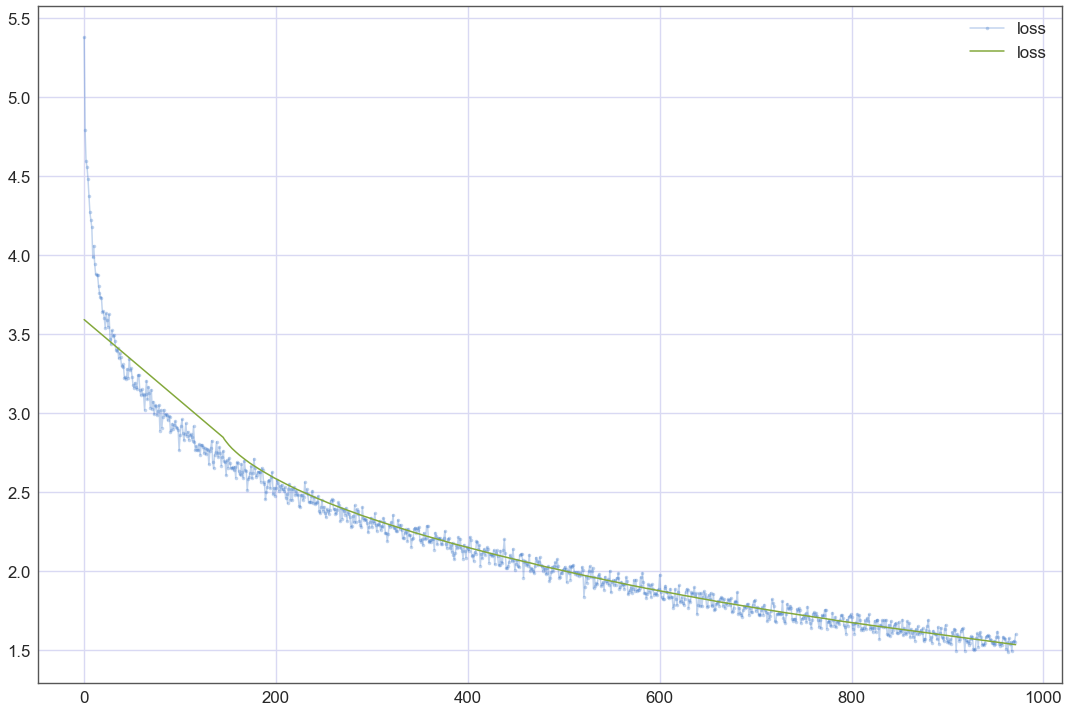

In [37]:
smooth_plot(history, remove_outlier=False)